In [29]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments
from datasets import load_dataset, concatenate_datasets
from peft import get_peft_model, get_peft_model_state_dict, set_peft_model_state_dict, LoraConfig, TaskType
from trl import SFTTrainer
import evaluate
import collections
import matplotlib.pyplot as plt


from fedn.utils.helpers.helpers import get_helper

from utils import *

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print(device)

cuda


In [31]:
# every client(hospital) gets their own category
    
dataset = load_dataset("NIH-CARD/CARDBiomedBench")

categories = [
    "Drug Gene Relations",
    "Pharmacology",
    "Drug Meta",
    "SNP Disease Relations",
    "SMR Gene Disease Relations"
]

train_datasets = []
test_datasets = []

for category in categories:
    filtered_train_ds = dataset["train"].filter(lambda x: x["bio_category"] == category)
    filtered_test_ds = dataset["test"].filter(lambda x: x["bio_category"] == category)
    filtered_train_ds = filtered_train_ds.shuffle(seed=42).select(range(1_000))
    filtered_test_ds = filtered_test_ds.shuffle(seed=42).select(range(100))
    train_datasets.append(filtered_train_ds)
    test_datasets.append(filtered_test_ds)
    
test_dataset = concatenate_datasets(test_datasets)

In [32]:
print(len(train_datasets))

5


## Centralized model (20% of total train data)

Train centralized model on datasplit (20% of total train data)

In [33]:
centralized_dataset = train_datasets[0]

In [34]:
# Load model and tokenizer
model = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model).to(device)

tokenizer.pad_token = tokenizer.eos_token 
model.config.pad_token_id = model.config.eos_token_id 

In [35]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    task_type=TaskType.CAUSAL_LM,
)

lora_model = get_peft_model(model, lora_config)

In [36]:
lora_model.print_trainable_parameters()

trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


## Centralized Fine-tuning

In [37]:
mapped_train_dataset = centralized_dataset.map(
    generate_instruction_format,
    remove_columns=centralized_dataset.column_names,
    batched=False,
)

In [38]:
model.train()

training_args = TrainingArguments(
    output_dir="qa-finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=5e-4,
    logging_steps=20,
    save_total_limit=2,
    use_cpu=not(use_cuda)
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=mapped_train_dataset
)

trainer.train()

Step,Training Loss
20,2.361900
40,1.555200
60,0.987400
80,0.812100


TrainOutput(global_step=96, training_loss=1.3191781640052795, metrics={'train_runtime': 71.2725, 'train_samples_per_second': 42.092, 'train_steps_per_second': 1.347, 'total_flos': 196176046321152.0, 'train_loss': 1.3191781640052795})

## Evaluation

In [39]:
def get_predictions(example):
    instruction = "You are a knowledgeable assistant. Answer this question truthfully!"

    question = example["question"]

    # Format the input the same way as during training
    prompt = (
        "### Instruction:\n"
        f"{instruction}\n\n"
        "### Input:\n"
        f"{question}\n\n"
        "### Response:\n"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
        )

    predicted_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # removes the prompt from the response
    predicted_output = predicted_output[len(prompt):]

    return {
        "question": example["question"],
        "predicted_output": predicted_output,
        "correct_output": example["answer"],
    }

In [40]:
def get_cached_predictions(dataset, filename_predictions, filename_references):
    if os.path.exists(filename_predictions) and os.path.exists(filename_references):
        print("Loading cached predictions")
        predictions = load_list(filename_predictions)
        references = load_list(filename_references)
    else:
        print("Generating new predictions")
        predictions_dataset = dataset.map(
            get_predictions,
            remove_columns=dataset.column_names
        )
        
        predictions = predictions_dataset["predicted_output"]
        references = predictions_dataset["correct_output"]
        
        save_list(predictions, filename_predictions)
        save_list(references, filename_references)
    
    return predictions, references

In [41]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_centralized.json", "model_predictions/references_centralized.json")

Loading cached predictions


In [42]:
centralized_results = compute_rouge(predictions, references)
centralized_results

{'rouge1': 0.423804138874244,
 'rouge2': 0.2497325563557798,
 'rougeL': 0.3655402217871792}

# Federated Fine-tuned model (all data)

In [43]:
HELPER_MODULE = "numpyhelper"
helper = get_helper(HELPER_MODULE)

In [44]:
def compile_model():
    model_name = "HuggingFaceTB/SmolLM2-135M"

    model = AutoModelForCausalLM.from_pretrained(model_name)

    model.config.pad_token_id = model.config.eos_token_id

    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.1,
        task_type=TaskType.CAUSAL_LM,
    )
    peft_model = get_peft_model(model, lora_config)
    return peft_model

def load_lora_parameters(model_path):
    """Loads the LoRA adaperts, not the full model"""
    peft_model = compile_model()
    parameters_np = helper.load(model_path)

    peft_model_statedict = get_peft_model_state_dict(peft_model)
    params_dict = zip(peft_model_statedict.keys(), parameters_np)
    lora_state_dict = collections.OrderedDict(
        {key: torch.tensor(x) for key, x in params_dict}
    )

    set_peft_model_state_dict(peft_model, lora_state_dict)

    return peft_model

In [45]:
# load model
path = "models/federated_finetuned_model_5rounds"
model = load_lora_parameters(path).to(device)

## Evaluation

In [46]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_federated.json", "model_predictions/references_federated.json")

Loading cached predictions


In [47]:
federated_results = compute_rouge(predictions, references)
federated_results

{'rouge1': 0.46110757296338395,
 'rouge2': 0.28580077590421776,
 'rougeL': 0.4264806954299763}

## Base model (not fine-tuned)

In [48]:
model_name = "HuggingFaceTB/SmolLM2-135M"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

tokenizer.pad_token = tokenizer.eos_token  
model.config.pad_token_id = model.config.eos_token_id 

In [49]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_base_model.json", "model_predictions/references_base_model.json")

Loading cached predictions


In [50]:
untrained_results = compute_rouge(predictions, references)
untrained_results

{'rouge1': 0.36626967459157195,
 'rouge2': 0.18639613312742703,
 'rougeL': 0.311329080652073}

## Extra: Centralized model on all data

In [51]:
train_dataset = concatenate_datasets(train_datasets)

In [52]:
model = "HuggingFaceTB/SmolLM2-135M"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(model).to(device)

tokenizer.pad_token = tokenizer.eos_token  
model.config.pad_token_id = model.config.eos_token_id 

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 460,800 || all params: 134,975,808 || trainable%: 0.3414


In [53]:
mapped_train_dataset = train_dataset.map(
    generate_instruction_format,
    remove_columns=train_dataset.column_names,
    batched=False,
)

In [54]:
model.train()

training_args = TrainingArguments(
    output_dir="qa-finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=5e-4,
    logging_steps=20,
    save_total_limit=2,
    use_cpu=not(use_cuda)
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=mapped_train_dataset
)

trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
20,2.441500
40,1.653300
60,1.232500
80,1.007700
100,0.861000
120,0.738500
140,0.646500
160,0.647900
180,0.588600
200,0.606500


TrainOutput(global_step=471, training_loss=0.7644693259220974, metrics={'train_runtime': 371.993, 'train_samples_per_second': 40.323, 'train_steps_per_second': 1.266, 'total_flos': 1221187120547328.0, 'train_loss': 0.7644693259220974})

## Evaluation

In [55]:
predictions, references = get_cached_predictions(test_dataset, "model_predictions/predictions_centralized_alldata.json", 
                                                          "model_predictions/references_centralized_alldata.json")

Loading cached predictions


In [56]:
all_data_centralized_results = compute_rouge(predictions, references)
all_data_centralized_results

{'rouge1': 0.6358682664434532,
 'rouge2': 0.5502847314543384,
 'rougeL': 0.6235409186659727}

## Plot ROUGE comparison

In [59]:
results = [untrained_results,
           centralized_results, 
           federated_results]

### ROUGE 1 Score

In [137]:
rouge_1_scores = [data['rouge1'] for data in results]
rouge_2_scores = [data['rouge1'] for data in results]
rouge_l_scores = [data['rouge1'] for data in results]

labels = ["Base model", "Centralized model", "Federated model"]

colors = ["tab:blue", "tab:orange", "tab:green"]

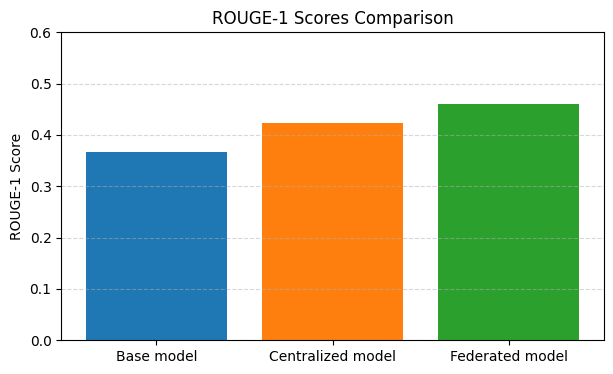

In [138]:
plt.figure(figsize=(7, 4))

bars = plt.bar(labels, rouge_1_scores, color=colors)

plt.title('ROUGE-1 Scores Comparison')
plt.ylabel('ROUGE-1 Score')
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### ROUGE 2 Score

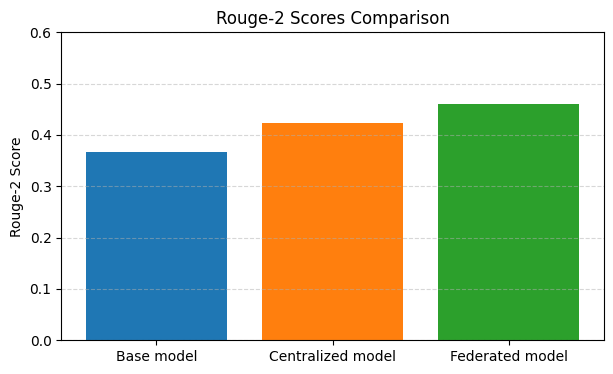

In [139]:
plt.figure(figsize=(7, 4))

bars = plt.bar(labels, rouge_2_scores, color=colors)

plt.title('Rouge-2 Scores Comparison')
plt.ylabel('Rouge-2 Score')
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

### ROUGE L Score

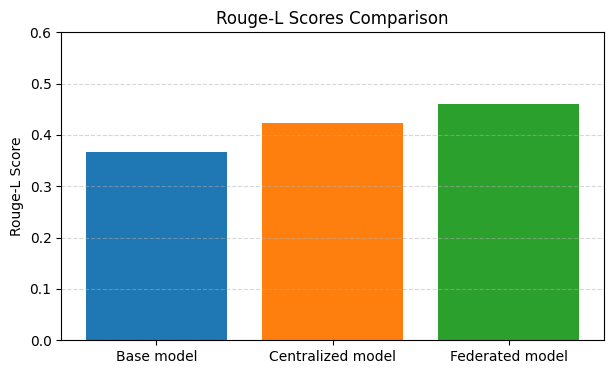

In [140]:
plt.figure(figsize=(7, 4))

bars = plt.bar(labels, rouge_l_scores, color=colors)

plt.title('Rouge-L Scores Comparison')
plt.ylabel('Rouge-L Score')
plt.ylim(0, 0.6)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()